In [11]:
#Cargando librerías 
import importlib

import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib as mpl
import itertools as it


#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import scipy as sp
import numpy as np
import pandas as pd
import os
import sys  

root = os.getcwd() + "/.."
sys.path.insert(0, root)

import src.positioning_sensors as ps
import src.regionGrowing as rg
import src.manageExperiments as me
import src.network_fitness as netfit

importlib.reload(ps)
importlib.reload(rg)
importlib.reload(me)
importlib.reload(netfit)

from geneticalgorithm import geneticalgorithm as ga



import config.config as cfg
importlib.reload(cfg)


<module 'config.config' from '/Users/rodrigo/Documents/SourcesCodes/GitHub/optimization-location-for-light-pollution-networks/notebooks/../config/config.py'>

In [12]:
fn = "config_exp_15062022_redo_exp.txt"
setup = me.readConfigFile(fn)

In [13]:

#Loading precalculated local and directed empirical variograms

filesv = (cfg.experiment + setup["experiment_id"] 
          + setup["folder_semivariances"] 
          + setup["output_semivariances"] 
          + ".csv"
         )

filesvmask = (cfg.experiment + setup["experiment_id"] 
              + setup["folder_semivariances"] 
              + setup["output_semivariances"] 
              + "mask.csv"
             )

OptimumValues = (cfg.experiment + setup["experiment_id"] 
                 + setup["folder_output"] 
                 + setup["output_values"]
                )

arguments = (cfg.experiment + setup["experiment_id"] 
             + setup["folder_output"] 
             + setup["output_args"]
            )


data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)
variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])



In [14]:

#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"] + setup["input_ntli"]
niveles = setup["folder_input"] + setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x = setup['filterg_sx']
sigma = [sigma_y, sigma_x]


#NLTI: luminance
luminance = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles, invert = True)

DNTLI, b = ps.desaturate(luminance, th = 63)

variograms = variogram_set.reshape(len(variogram_set), 
                                   DNTLI.shape[0], 
                                   DNTLI.shape[1]
                                  )
variograms_m = variogram_set_m.reshape(len(variogram_set), 
                                       DNTLI.shape[0],DNTLI.shape[1])

coords = np.array(data.iloc[:, 1:3])

FDNTLI = sp.ndimage.gaussian_filter(DNTLI, sigma, 
                                    mode = setup['gaussian_mode']
                                   )

FDNTLI = (FDNTLI >= setup['neglect_values'])*FDNTLI

sensitivity = ps.f5(FDNTLI, EAM, 64)

 W = i*a^(p)


In [ ]:
#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"] + setup["input_ntli"]
niveles = setup["folder_input"] + setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x = setup['filterg_sx']
sigma = [sigma_y,sigma_x]


In [18]:
aptitude = netfit.NetworkFitness(FDNTLI, EAM, sensitivity, variograms, variograms_m, coords)
aptitude.selectFitnessFunction("max")


Selct cost functions: 
 'xor','max' or 'cover'


In [19]:

#for c in setup["sensitivity_c"]:
#    S = ps.f5(FDNTLI,EAM,c)
#    scientific_notation="{:2.4e}".format(np.sum(S*(FDNTLI>0)))
#    print(scientific_notation)


In [20]:
#res_df= pd.DataFrame(results)
#res_df.to_csv("results_7x7.csv")
res_read = pd.read_csv(OptimumValues)
rr = np.array(res_read)
r = list([])
for i,j in enumerate(rr):
    r.append(j[1:(1)+((i % 7) +1)*2])

In [21]:

R = (aptitude.project(r[48])+(FDNTLI>0)*1).astype(int)


In [22]:
def plotSolutions(p,img):

    z = np.copy(img)
    cs = int(9)

    a = p.reshape(-1,2)
    for b in a:
        c = b.astype(int)
        z[tuple(c)] = 2
        z[tuple([c[0]+1,c[1]])]=cs
        z[tuple([c[0]+1,c[1]+1])]=cs
        z[tuple([c[0],c[1]+1])]=cs
        z[tuple([c[0]-1,c[1]-1])]=cs
        z[tuple([c[0]-1,c[1]])]=cs
        z[tuple([c[0]-1,c[1]+1])]=cs
        z[tuple([c[0],c[1]-1])]=cs
        z[tuple([c[0]+1,c[1]-1])]=cs
        

    return z

P = plotSolutions(r[2],R)

In [23]:
R = plotSolutions(r[48], (FDNTLI>0)*1).astype(int)   

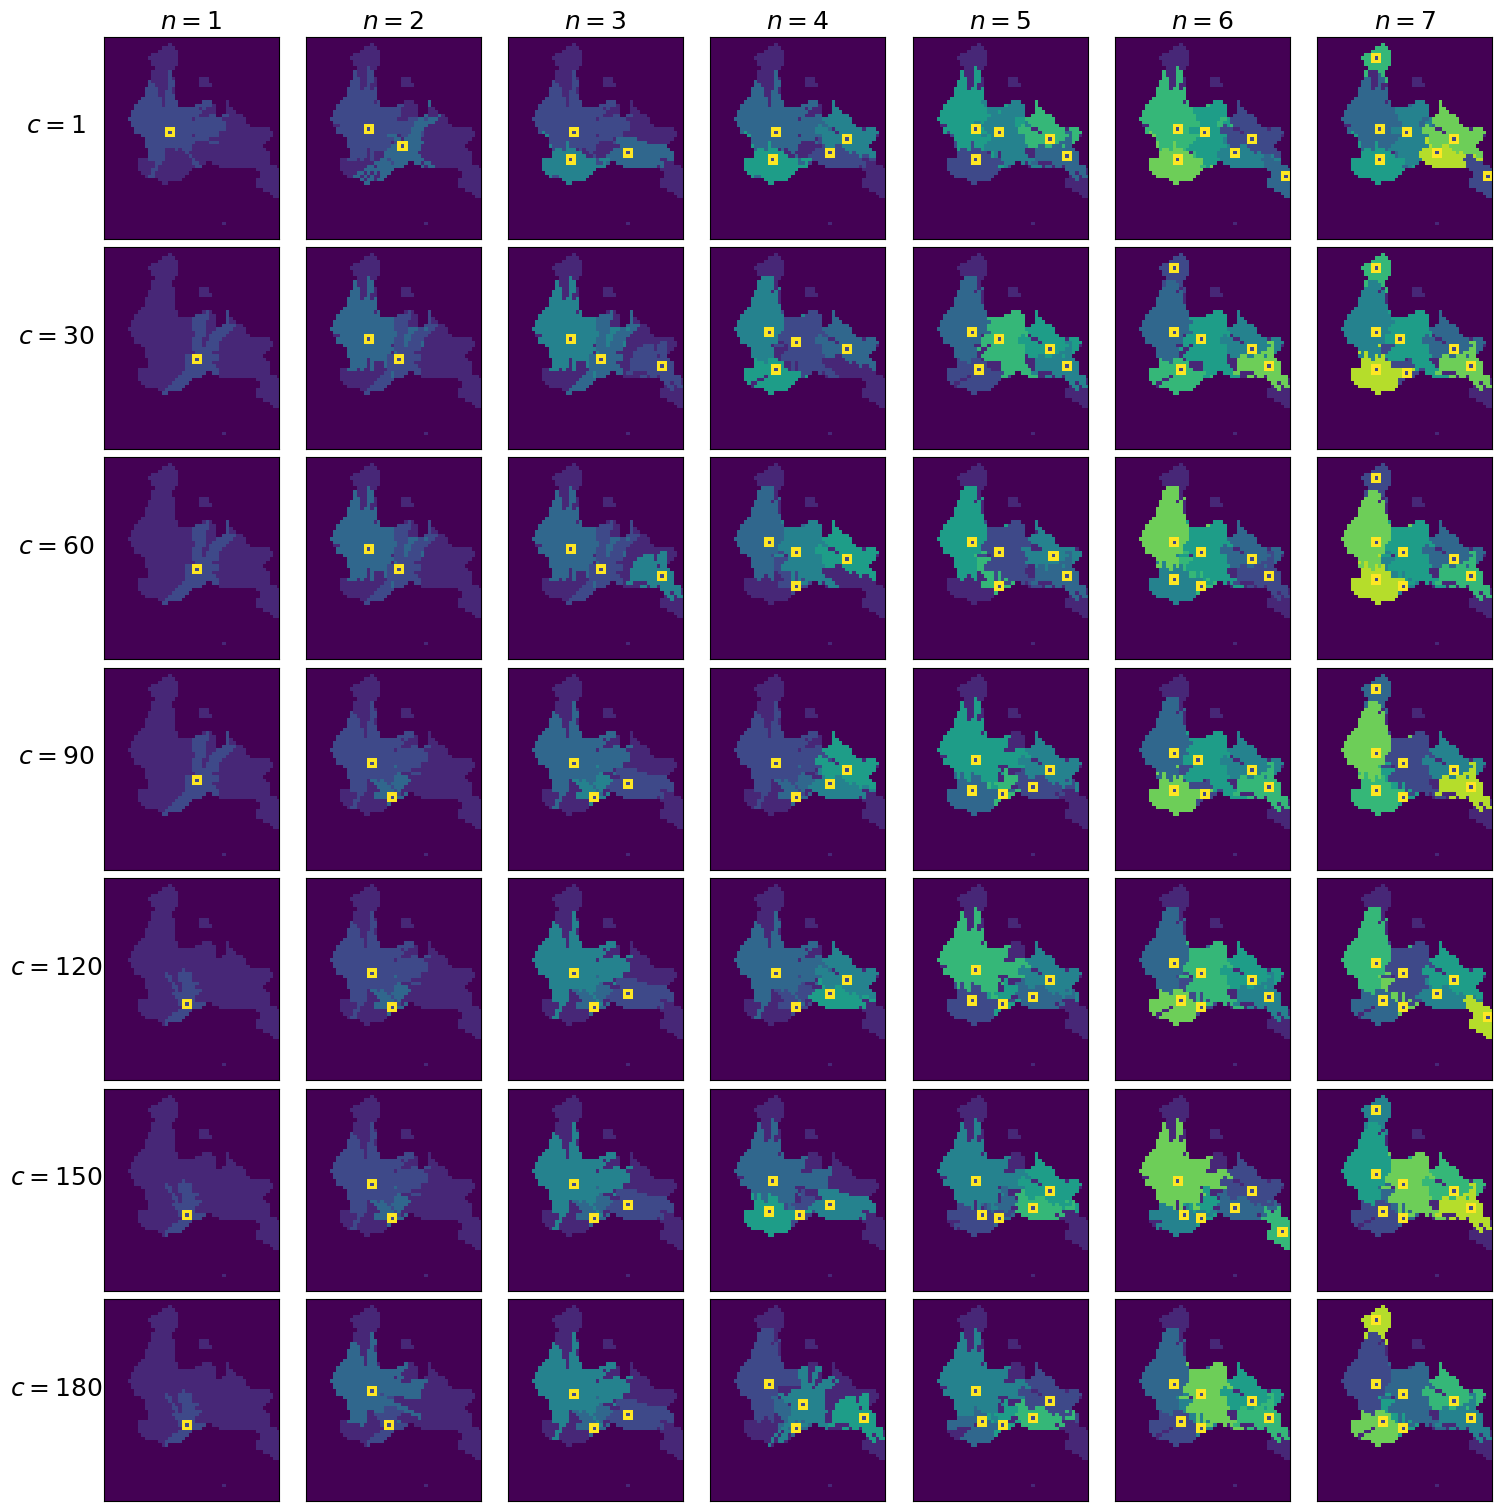

In [24]:

fig, axs = plt.subplots(ncols=7, nrows=7, figsize=(15, 15),constrained_layout=True)

# add an artist, in this case a nice label in the middle...
ix = 0
saveR = np.zeros(R.shape)
f = 0
c = setup["sensitivity_c"]
for row in range(len(c)):
    for col in range(7):
        R = (aptitude.project(r[ix])+(FDNTLI>0)*1).astype(int)
        PS = plotSolutions(r[ix],R)
     #   R = plotSolutions(r[ix],(FDNTLI>0)*1).astype(int)
    #    R = plotSolutions(r[ix],R)
        #R_and_locations = AttachLocations(R,results)
        axs[row,col].imshow(PS,cmap="viridis",interpolation='none')

        if col==0: 
            axs[row, col].set_ylabel("$c={c: 1.0f}$".format(c = c[row]),rotation = 0,fontsize=18)
            axs[row, col].yaxis.set_label_coords(-.27, .5)
        if row==0: 
            axs[row, col].set_title('$n = {n: 1.0f}$'.format(n=col+1),fontsize=18)
            #axs[row, col].set_xlabel("n = {n: 1.0f}".format(n=col+1))
            
        axs[row, col].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

        ix += 1


plt.savefig("covers64_2.pdf",format='pdf', dpi=500,bbox_inches="tight")

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


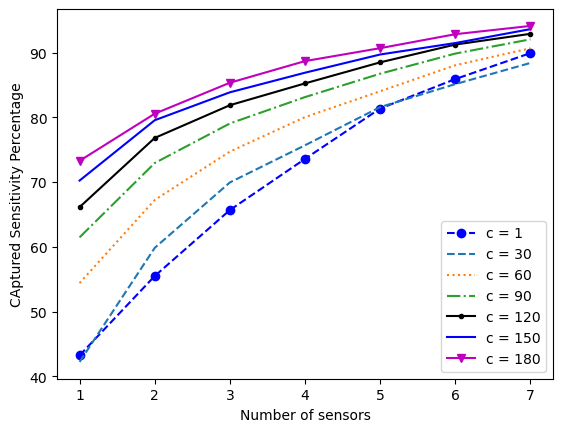

In [26]:
aptitudes = np.array(pd.read_csv(arguments))[:, 1]

fig, ax = plt.subplots()
styles = ['--bo', '--', ':', '-.', '.-k', 'b', '-vm']
for i in range(7):
    
    ax.plot(-aptitudes.reshape(7, 7).T[:, i]*100, styles[i], label = "c = " + str(c[i]))

ax.set_xticks([i for i in range(len(c))])
ax.set_xticklabels([i + 1 for i in range(len(c))])
ax.set_ylabel(r"CAptured Sensitivity Percentage")
ax.set_xlabel("Number of sensors")
ax.legend()
plt.savefig("ExplainedSensitivity64.eps",bbox_inches="tight")
plt.show()

In [28]:
nonsat,b = ps.desaturate(luminance,th=setup["desaturation_th"])

variograms = variogram_set.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
coords = np.array(data.iloc[:,1:3])
NLTI = sp.ndimage.gaussian_filter(nonsat, sigma, mode='constant')
NLTI = (NLTI>=setup["neglect_values"])*NLTI

In [30]:


sensitivity = ps.f5(NLTI,EAM,1)
nf = netfit.NetworkFitness(NLTI,EAM,sensitivity,variograms,variograms_m,coords)
nf.selectFitnessFunction("max")
f = nf.f

solutions = list([])

for rx in r:  
    solutions.append(f(rx))


 W = i*a^(p)
Selct cost functions: 
 'xor','max' or 'cover'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


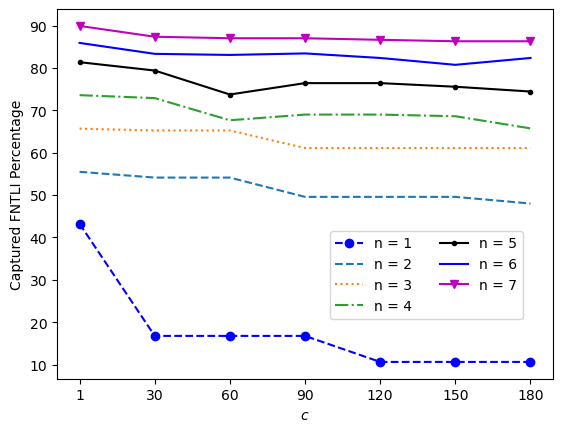

In [31]:
M = np.array(solutions).reshape(7,7)

cf = 1 
fig, ax = plt.subplots()
styles = ['--bo', '--', ':', '-.', '.-k', 'b', '-vm']
for i in range(7):
    ax.plot(-M[:, i]*100, styles[i], label = "n = " + str(i + 1))

ax.set_xticks([i for i in range(len(c))])
ax.set_xticklabels(c)
ax.set_ylabel(r"Captured FNTLI Percentage")
ax.set_xlabel("$c$")
ax.legend(ncol=2,bbox_to_anchor=(0.55, 0.4), loc='upper left', borderaxespad=0)
plt.savefig("ExplainedFNDTLI64.eps",bbox_inches="tight")
plt.show()

In [15]:
df = -pd.DataFrame(aptitudes.reshape(7, 7))

df


,0,1,2,3,4,5,6
0,0.432306,0.554903,0.656847,0.735909,0.813731,0.859229,0.899340
1,0.422204,0.598428,0.699514,0.756925,0.815930,0.851429,0.884144
2,0.544046,0.672417,0.747130,0.800465,0.840395,0.880576,0.906809
3,0.614685,0.729473,0.790633,0.831363,0.867501,0.898612,0.920612
4,0.661329,0.768245,0.818848,0.852544,0.885045,0.912546,0.929136
5,0.702397,0.795604,0.838753,0.869053,0.897183,0.914883,0.936379
6,0.732894,0.805706,0.853546,0.886995,0.906960,0.928550,0.941321


In [16]:
df.to_csv("results.csv")